# Using the Definitions
> Outputting the regions based the legal definitions

According to [SCOTCHWHISKY.com](https://scotchwhisky.com/magazine/ask-the-professor/22589/how-are-scotch-whisky-regions-different/) there is a legal definition to the regions. This can be found at [Legislation.gov.uk](https://www.legislation.gov.uk/uksi/2009/2890/regulation/10/made) under "The Scotch Whisky Regulations 2009" regulation 10. It is summarised below:

* **Campbeltown**: comprising the South Kintyre ward of the Argyll and Bute Council as that ward is constituted in the Argyll and Bute (Electoral Arrangements) Order 2006(1)
* **Islay**: comprising the Isle of Islay in Argyll.
* **Highland**: comprising that part of Scotland that is north of the line dividing the Highland region from the Lowland region;
* **Lowland**: comprising that part of Scotland that is south of the line dividing the Highland region from the Lowland region; and
* **Speyside**: comprising
  - the wards of Buckie, Elgin City North, Elgin City South, Fochabers Lhanbryde, Forres, Heldon and Laich, Keith and Cullen and Speyside Glenlivet of the Moray Council as those wards are constituted in the Moray (Electoral Arrangements) Order 2006(2)
  - the Badenoch and Strathspey ward of the Highland Council as that ward is constituted in the Highland (Electoral Arrangements) Order 2006(3).

In this regulation "the line dividing the Highland region from the Lowland region" means the line beginning at the North Channel and running along the southern foreshore of the Firth of Clyde to Greenock, and from there to Cardross Station, then eastwards in a straight line to the summit of Earl’s Seat in the Campsie Fells, and then eastwards in a straight line to the Wallace Monument, and from there eastwards along the line of the B998 and A91 roads until the A91 meets the M90 road at Milnathort, and then along the M90 northwards until the Bridge of Earn, and then along the River Earn until its confluence with the River Tay, and then along the southern foreshore of that river and the Firth of Tay until it comes to the North Sea.

For my purposes I will also separate out **Highland** and **Island** regions by the following additional definitions:
* **Highland** comprising of the subsection of the **Highland** region as defined above, that is wholly on the Scottish mainland.
* **Island** comprising of the subsection of the **Highland** region as defined above, that is wholly *not* on the Scottish mainland.

In [18]:
import requests
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

import geopandas as gpd
import pandas as pd
import shapely
from shapely import Polygon, MultiPolygon, Point, LineString
from shapely.ops import split

from whisky_regions import Plotter

## Setting Up and DataFrame to Recieve the Geometries

In [19]:
regions_gdf: gpd.GeoDataFrame = gpd.GeoDataFrame(columns=["Name", "area"], geometry="area", crs=4326)

## Retrieving Available Ward Data
Cambeltown and Speyside derive their region mappings from electoral wards. The ward mappings can be found from the [Office for National Statistics](https://www.data.gov.uk). In this case I have found and used the 2020 dataset as opposed to the 2006 dataset specified in the Act.

In [20]:
regions_by_wards: dict[str, list[str]] = {
    "Cambeltown": [
        "South Kintyre",
    ],
    "Speyside": [
        "Buckie",
        "Elgin City North",
        "Elgin City South",
        "Fochabers Lhanbryde",
        "Forres",
        "Heldon and Laich",
        "Keith and Cullen",
        "Speyside Glenlivet",
        "Badenoch and Strathspey",
    ],
}

In [21]:
def return_ward_geodataframe(wardname: str) -> Polygon | MultiPolygon:
    crs = 4326
    params = {
        "where": f"WD20NM='{wardname}'",
        "outFields": "*",
        "outSr": crs,
        "f": "geojson"
    }
    
    url = "https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/Wards_Dec_2020_UK_BGC_2022/FeatureServer/0"
    response = requests.get(f"{url}/query", params=params)
    geojson = response.json()
    
    return gpd.GeoDataFrame.from_features(geojson, crs=crs)["geometry"][0]

Processing 1 for "Cambeltown" region.
Processing 9 for "Speyside" region.


<Axes: >

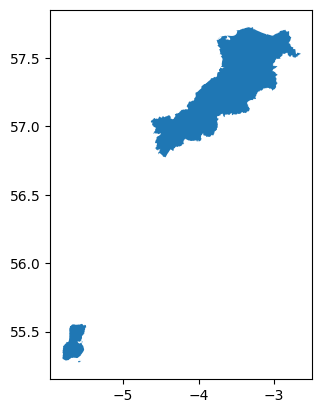

In [22]:
for region, wards in regions_by_wards.items():
    print(f"Processing {len(wards)} for \"{region}\" region.")
    
    geometries: list[Polygon | MultiPolygon] = [return_ward_geodataframe(ward) for ward in wards]
    shapely.unary_union(geometries)
    
    new_region: gpd.GeoDataFrame = gpd.GeoDataFrame(
        [{"Name": region, "area": shapely.unary_union(geometries)}],
        geometry="area",
    crs=4326,
    )
    
    regions_gdf = pd.concat([regions_gdf, new_region], ignore_index=True)

regions_gdf.plot()

## Extracting Islay Polygon

I created a rough polygon using QGIS surrounding Islay. This gets imported and then intersected with the ward of "Kintyre and the Islands" which contains Islay. The resulting intersection should be the island itself.

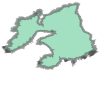

In [23]:
islay_rough_bbox: Polygon = gpd.read_file("islay_bbox.gpkg")["geometry"][0]
ward_containing_islay: Polygon | MultiPolygon = return_ward_geodataframe("Kintyre and the Islands")

islay: Polygon | MultiPolygon = shapely.intersection(islay_rough_bbox, ward_containing_islay)

islay

In [24]:
islay_region: gpd.GeoDataFrame = gpd.GeoDataFrame(
    [{"Name": "Islay", "area": islay}],
    geometry="area",
    crs=4326,
)

regions_gdf = pd.concat([regions_gdf, islay_region], ignore_index=True)

<Axes: >

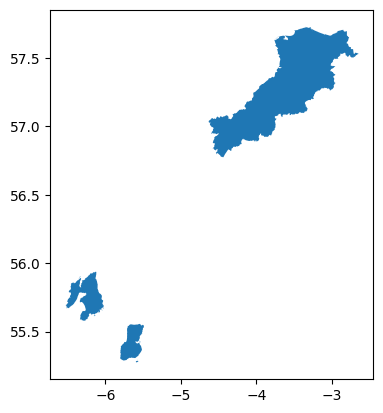

In [25]:
regions_gdf.plot()

## Retrieve Scotland Shape
Extracting the Scotland shape is useful for both finding the remainder of the regions, and as a base map.

In [26]:
crs = 4326
params = {
    "where": f"CTRY20NM='Scotland'",
    "outFields": "*",
    "outSr": crs,
    "f": "geojson"
}

url = "https://services1.arcgis.com/ESMARspQHYMw9BZ9/arcgis/rest/services/Countries_December_2020_UK_BGC_2022/FeatureServer/0"
response = requests.get(f"{url}/query", params=params)
geojson = response.json()

scotland_gdf: gpd.GeoDataFrame = gpd.GeoDataFrame.from_features(geojson, crs=crs)
scotland: Polygon | MultiPolygon = scotland_gdf["geometry"][0]

## Remaining Area
We clip the Scotland map with the already determined regions to find the remainder which will include Lowland and Highland (and Islands).

In [27]:
already_defined_regions: Polygon | MultiPolygon = shapely.unary_union(
    [region for region in regions_gdf["area"]]
)

undefined_region: MultiPolygon = shapely.difference(scotland, already_defined_regions)
mainland_undefined: Polygon = max(undefined_region.geoms, key=lambda a: a.area)

## Extract Islands Regions

In [28]:
islands: MultiPolygon = shapely.difference(undefined_region, mainland_undefined)

islands_region: gpd.GeoDataFrame = gpd.GeoDataFrame(
    [{"Name": "Islands", "area": islands}],
    geometry="area",
    crs=4326,
)

regions_gdf = pd.concat([regions_gdf, islands_region], ignore_index=True)

<Axes: >

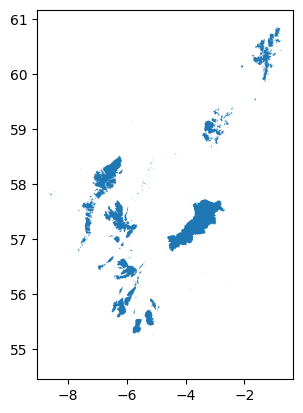

In [29]:
regions_gdf.plot()

## Finding the Dividing Line
The dividing line was created using QGIS, and some open Ornance Survey data (OS Open Roads, and OS Open Rivers).

In [30]:
dividing_line: LineString = gpd.read_file("roads_and_rivers.gpkg", layer="dividing_line")["geometry"][0]

gdf = gpd.GeoDataFrame({'geometry': split(mainland_undefined, dividing_line).geoms})

In [31]:
highland_landmasses: list[Polygon] = []
lowland_landmasses: list[Polygon] = []

for landmass in split(mainland_undefined, dividing_line).geoms:
    
    if shapely.get_y(shapely.centroid(landmass)) > shapely.get_y(shapely.centroid(dividing_line)):
        
        if shapely.get_x(shapely.centroid(landmass)) < shapely.get_x(shapely.centroid(dividing_line)):
            highland_landmasses.append(landmass)
            
        else:
            lowland_landmasses.append(landmass)
            
    else:
        lowland_landmasses.append(landmass)

In [32]:
highland_region: gpd.GeoDataFrame = gpd.GeoDataFrame(
    [{"Name": "Highlands", "area": shapely.unary_union(highland_landmasses)}],
    geometry="area",
    crs=4326,
)
lowland_region: gpd.GeoDataFrame = gpd.GeoDataFrame(
    [{"Name": "Lowlands", "area": shapely.unary_union(lowland_landmasses)}],
    geometry="area",
    crs=4326,
)

regions_gdf = pd.concat([regions_gdf, highland_region, lowland_region], ignore_index=True)

## Plot Results

<Axes: >

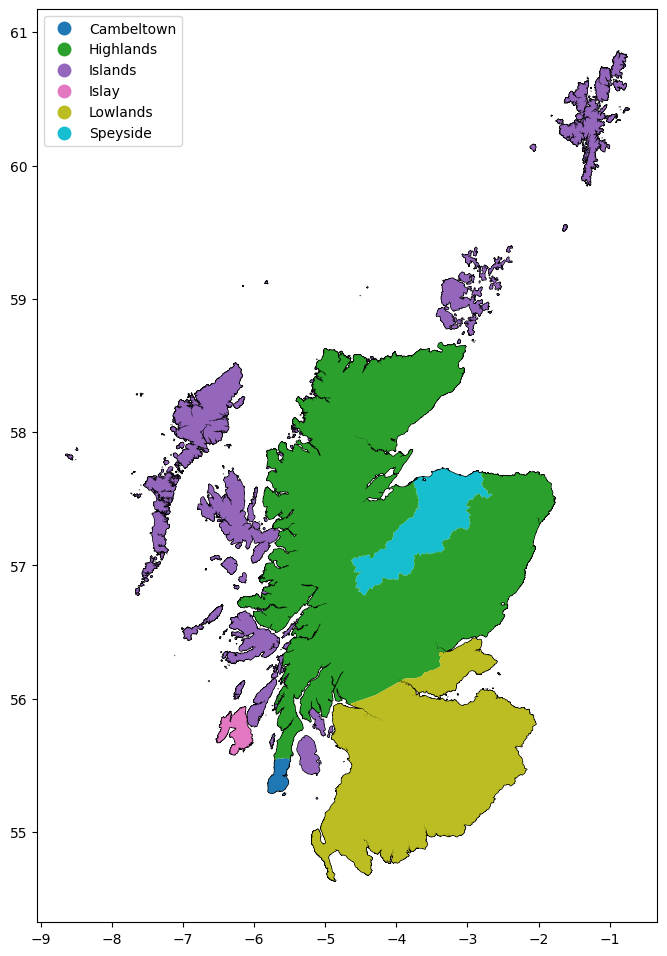

In [33]:
plotter = Plotter(
    base_map=scotland_gdf,
)
plotter.add_regions(
    regions=regions_gdf,
)
plotter.plot

## Export Results

In [34]:
regions_gdf.to_file(
    filename="output/whisky_regions.gpkg",
    driver="GPKG",
    layer="regions",
)

plotter.save_figure("legal")